In [17]:
import numpy as np
import pandas as pd
import re
from bs4 import BeautifulSoup
import unicodedata
from nltk.tokenize.toktok import ToktokTokenizer
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.preprocessing.text import Tokenizer
from tqdm import tqdm
import codecs
import nltk
import matplotlib.pyplot as plt

In [3]:
data = '/Users/beichen/OneDrive - University of Nebraska-Lincoln/Research_Projects/Twitter_Drought/Data/Tweets/tweets_17-20.csv'
df = pd.read_csv(data, index_col=0)
text = df.loc[:,"text"].values
text

array(['@conejorpd doing right by the environment by saving water ???? 6million gallons &amp; $7000/year #drought @nrpa_news https://t.co/kcnpc34srp',
       'updated california #rainfall totals between #storms. #cawater #drought #cawx https://t.co/iadovoueug',
       'if only there was a way to capture water, when we have too much, and save it until we have too little... #drought  https://t.co/7retabm6gn',
       ...,
       'upcoming webinar tomorrow june 18, 1-2:15 pm pdt\r\norganization: @itep_cc\r\ntopic: the colorado river basin drought c� https://t.co/03dmuxuud9',
       "six western states are telling utah to hold up. @ap's @metzsam has more on the fight over the colorado river:� https://t.co/g6kd6fcca8",
       "you should know that here in las vegas where we haven't seen rain in over 5 months, we suck the colorado river dry� https://t.co/iurdokufrn"],
      dtype=object)

In [4]:
df

,id_str,from_user,text,user_location,date,lat_o,lon_o
1,8.182851e+17,1BHK1,@conejorpd doing right by the environment by s...,"westlake village, ca",2017-01-09,34.146647,-118.807373
2,8.184620e+17,agleader,updated california #rainfall totals between #s...,central california,2017-01-09,38.392780,-121.571940
3,8.183370e+17,benavey,"if only there was a way to capture water, when...","fair oaks, ca",2017-01-09,38.644626,-121.272172
4,8.184502e+17,CaliDarlin,it ain't raining men but it sure as hell is ra...,city of angels,2017-01-09,34.052234,-118.243685
5,8.185824e+17,CallMichele,we have water in northern california .... ????...,"roseville, ca",2017-01-09,38.752124,-121.288006
...,...,...,...,...,...,...,...
26650,1.238382e+18,Doug_Blatchford,excellent discussion today at continuing law e...,"boulder city, nevada",2020-03-13,35.978222,-114.834512
26651,1.256612e+18,sdcwa,last #sierranevada @ca_dwr snowpack survey of ...,san diego county,2020-05-02,32.715730,-117.161097
26652,1.273342e+18,sc_casc,"upcoming webinar tomorrow june 18, 1-2:15 pm p...","norman, ok",2020-06-17,35.222567,-97.439478
26653,1.304091e+18,susanmbryanNM,six western states are telling utah to hold up...,"albuquerque, nm",2020-09-10,35.084386,-106.650422


In [5]:
user_location = df.loc[:,"user_location"]
states_list = []
for s in user_location.values:
    punc = ','
    if punc in s:
        state = s.split(',')[1]
        states_list.append(state)
    else:
        states_list.append(s)

In [6]:
new_states_lists = []
for idx,s in enumerate(states_list):
    if s in [' california', ' California', ' ca']:
        states_list[idx] = 'ca'


In [7]:
dir_l1 = '/Users/beichen/OneDrive - University of Nebraska-Lincoln/Research_Projects/Twitter_Drought/Data/DIR/us_state.csv'
dir_l2_1 = '/Users/beichen/OneDrive - University of Nebraska-Lincoln/Research_Projects/Twitter_Drought/Data/DIR/us_county_2011_2015.csv'
dir_l2_2 = '/Users/beichen/OneDrive - University of Nebraska-Lincoln/Research_Projects/Twitter_Drought/Data/DIR/us_county_2016.csv'
dir_l2_3 = '/Users/beichen/OneDrive - University of Nebraska-Lincoln/Research_Projects/Twitter_Drought/Data/DIR/us_county_2017_2020.csv'
dir_l3 = '/Users/beichen/OneDrive - University of Nebraska-Lincoln/Research_Projects/Twitter_Drought/Data/DIR/us_city.csv'

df_l1 = pd.read_csv(dir_l1)
df_l3 = pd.read_csv(dir_l3)
df_l2_1 = pd.read_csv(dir_l2_1)
df_l2_2 = pd.read_csv(dir_l2_2)
df_l2_3 = pd.read_csv(dir_l2_3)

df_l2 = pd.concat([df_l2_1,df_l2_2,df_l2_3])
df_dir = pd.concat([df_l1,df_l2,df_l3])
df_dir

,Impact ID,Title,Post Date,Start Date,End Date,Description,Categories,Places,Unnamed: 8
0,53728,Maine Drought Task Force closed,12/18/2020,12/17/2020,,The Maine Drought Task Force met on Dec. 17 to...,"Relief, Response & Restrictions, Water Supply ...",Maine,NaN
1,53727,Drought status easing in Connecticut,12/18/2020,12/15/2020,,The Connecticut drought workgroup voted to imp...,"Relief, Response & Restrictions, Water Supply ...","Connecticut, New Haven County, CT",NaN
2,53713,Outdoor water bans remain in New Hampshire,12/16/2020,12/10/2020,,"Precipitation eased drought in New Hampshire, ...","Relief, Response & Restrictions, Water Supply ...","New Hampshire, Merrimack County, NH, Rockingha...",NaN
3,53721,Hay quality and supplies discussed at talk hos...,12/18/2020,12/09/2020,,Hay quality in Maine has been affected by drou...,"Agriculture, Plants & Wildlife, Relief, Respon...",Maine,NaN
4,53718,Municipal portion of Colorado's drought plan a...,12/17/2020,12/01/2020,,Colorado shifted from Phase 2 to Phase 3 (full...,"Relief, Response & Restrictions, Water Supply ...",Colorado,NaN
...,...,...,...,...,...,...,...,...,...
4074,28315,"Herd of mule deer living in Alamosa, Colorado ...",04/23/2013,04/23/2002,04/23/2013,Between 300 and 500 mule deer have called Alam...,"Plants & Wildlife, Society & Public Health","Alamosa, CO",NaN
4075,33657,"Water scarcity taught lettuce growers in Yuma,...",05/11/2016,01/01/2002,05/10/2016,Yuma farmers have been dealing with drought fo...,Agriculture,"Yuma, AZ",NaN
4076,28447,"Drought brings blowing soils, increased fire r...",05/14/2013,01/01/2000,05/11/2013,I'm a district wildlife manager w/Colorado Div...,"Agriculture, Fire, Plants & Wildlife, Society ...","Lincoln County, CO, Limon, CO",NaN
4077,28005,"Trees stressed in Denver, Colorado",01/04/2013,06/17/1998,09/12/2012,Many trees are very stressed with scorched or ...,Plants & Wildlife,"Denver County, CO, Denver, CO",NaN


In [8]:
df_dir_norepeat = df_dir.drop_duplicates(subset='Impact ID')

In [9]:
dir_dscrip_length = df_dir_norepeat.Description.map(len)
dir_dscrip_length

0        244
1        287
2        236
3        345
4        851
        ... 
4071     773
4073    1984
4074     283
4075     470
4078     361
Name: Description, Length: 14178, dtype: int64

In [11]:
df_dir_norepeat.to_csv("DIR_2011_2020.csv")

In [9]:
print(dir_dscrip_length.idxmax())
df_dir_norepeat.iloc[4073,:].Description

974


'Dunn County commissioners sent a request to North Dakota Gov. Jack Dalrymple to approve restrictions on the hours during which hunters may hunt, due to drought and fire concerns.  Whereas hunting is typically allowed from one half hour before sunrise to one half hour after sunrise, the proposal is to limit hunting from sunrise to noon.Billings, Bowman and Slope county authorities also discussed the same limitation on hunting hours, but did not send a request to the governor, as Dunn County officials did.Dickinson Press (N.D.), Sept. 7, 2012'

In [23]:
dir_dscrip_words = df_dir_norepeat.Description.str.split().str.len()
dir_dscrip_words.sum()

1095927

In [43]:
df_dir_cleaned = pd.DataFrame({"cleaned_dir": dir_cleaned})
dir_cleaned_words = df_dir_cleaned.cleaned_dir.str.split().str.len()
dir_cleaned_words

0         25
1         30
2         24
3         34
4         83
        ... 
14173     69
14174    199
14175     27
14176     43
14177     34
Name: cleaned_dir, Length: 14178, dtype: int64

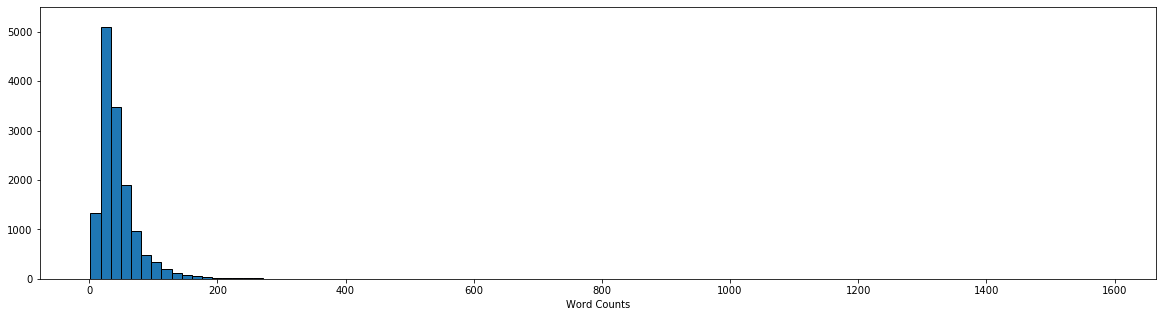

In [46]:
plt.figure(figsize = (20,5))
(n, bins, patches) = plt.hist(dir_cleaned_words.values, bins = 100, edgecolor='black', linewidth=1)
plt.ylim((0,5500))
plt.xlabel('Word Counts')
plt.show()

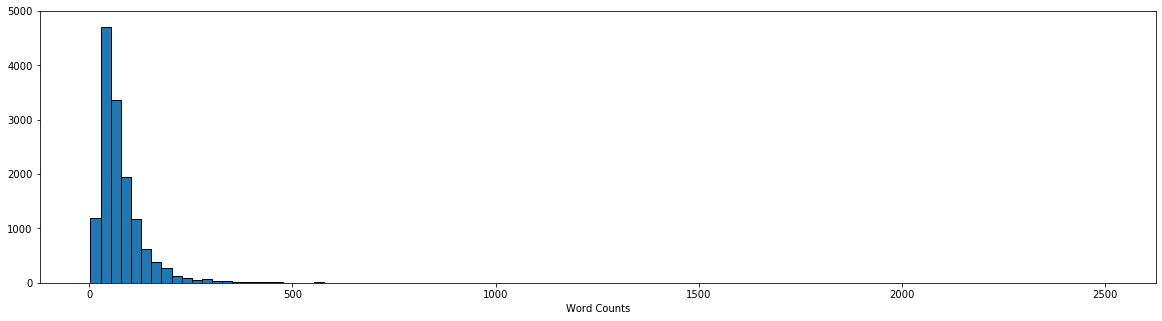

In [13]:
plt.figure(figsize = (20,5))
(n, bins, patches) = plt.hist(dir_dscrip_words.values, bins = 100, edgecolor='black', linewidth=1)
plt.ylim((0,5000))
plt.xlabel('Word Counts')
plt.show()

In [14]:
n[0:10].sum()/n.sum()

0.979193116095359

In [14]:
df_dir_norepeat_removeMax = df_dir_norepeat.drop(df_dir_norepeat.index[974])

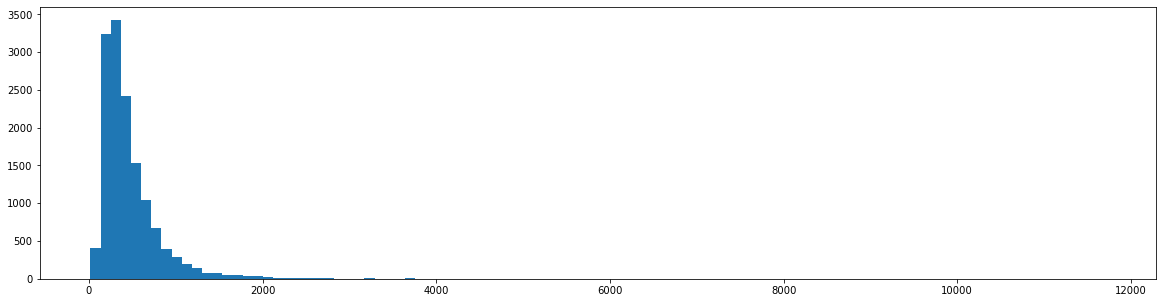

In [15]:
plt.figure(figsize = (20,5))
plt.hist(df_dir_norepeat_removeMax.Description.map(len).values, bins = 100)
plt.show()

In [24]:
#title
dir_title_words = df_dir_norepeat.Title.str.split().str.len()
dir_title_words.sum()

143260

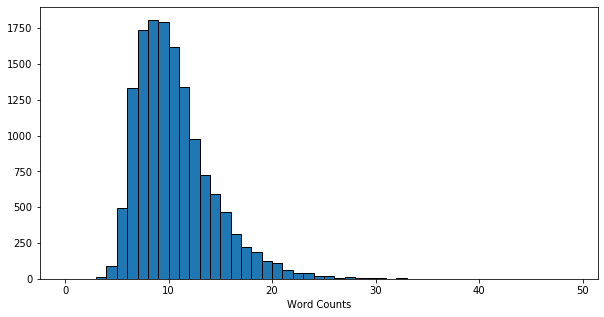

In [65]:
plt.figure(figsize = (10,5))
(n, bins, patches) = plt.hist(dir_title_words.values, bins = range(50), edgecolor='black', linewidth=1)
#plt.ylim((0,5500))
plt.xlabel('Word Counts')
plt.show()

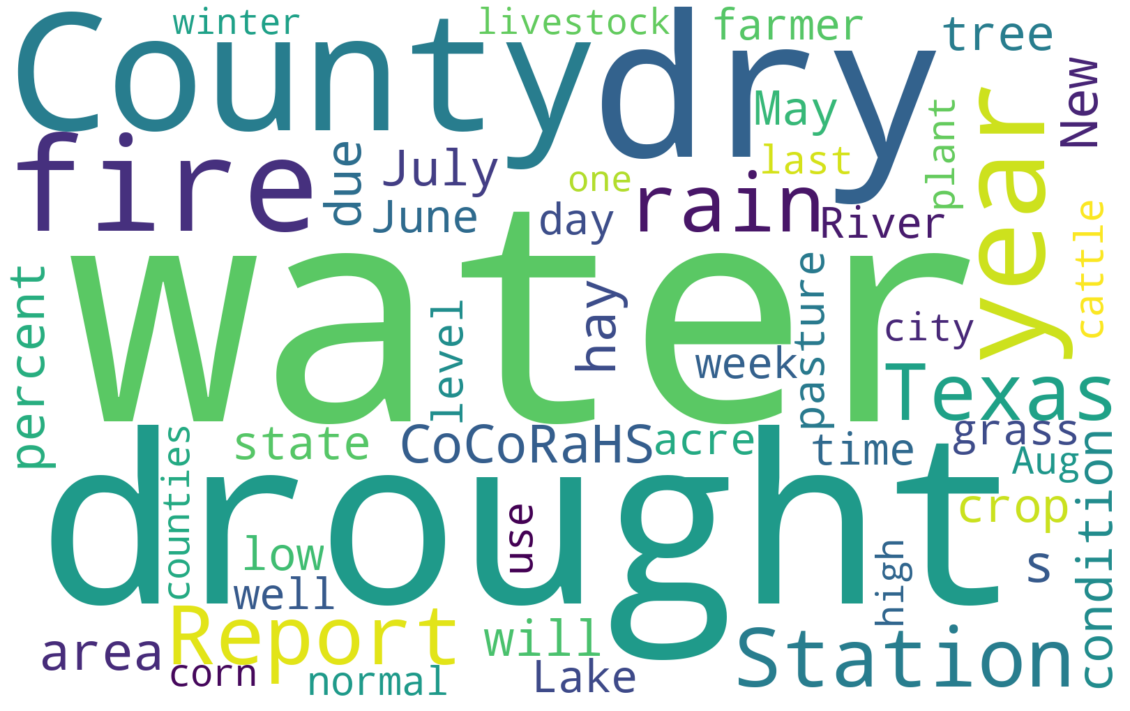

In [81]:
plt.figure(figsize = (20,20)) 
wc = WordCloud(max_words = 50 , width = 1600 , height = 1000,background_color = "white",collocations=False).generate(" ".join(df_dir_norepeat.Description.values))
plt.imshow(wc , interpolation = 'bilinear')
plt.axis('off')
plt.savefig("wordcloud_dir.png")

In [19]:
category_idx = ['Agriculture', 'Business & Industry', 'Energy', 'Fire', 'Plants & Wildlife', 'Relief, Response & Restrictions', 'Society & Public Health', 'Tourism & Recreation', 'Water Supply & Quality']
category_dict = {'Agriculture': 1, 
                'Business & Industry':2,
                'Energy': 2,
                'Fire': 3,
                'Plants & Wildlife': 4,
                'Relief, Response & Restrictions': 5,
                'Society & Public Health': 6,
                'Tourism & Recreation': 2,
                'Water Supply & Quality': 7
                }

In [16]:
labels_list = []
for row in df_dir_norepeat.Categories.str.split(', '):
    row_labels = []
    for i in row:
        if i == 'Relief':
            i = 'Relief, Response & Restrictions'
        if i in category_idx:
            row_labels.append(category_dict[i])
    labels_list.append(row_labels)

In [17]:
from collections import Counter
flat_labels_list = [item for sublist in labels_list for item in sublist]
counts_impacts = Counter(flat_labels_list)
counts_impacts

Counter({5: 4591, 7: 5369, 1: 5894, 4: 4617, 3: 2980, 2: 1731, 6: 1800})

In [21]:
new_category_idx = ['Agriculture', 'Economy', 'Fire', 'Plants & Wildlife', 'Relief, Response & Restrictions', 'Society & Public Health', 'Water Supply & Quality']

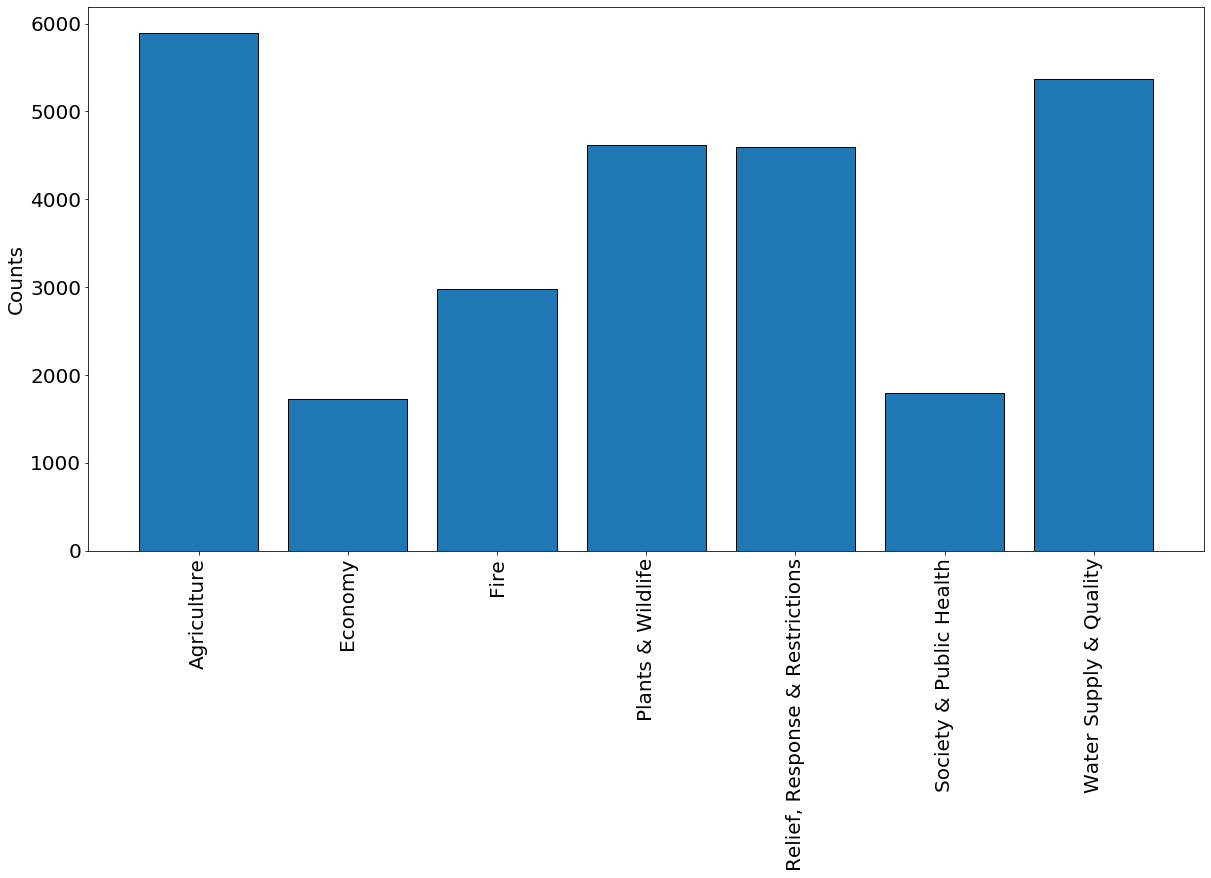

In [22]:
plt.figure(figsize = (20,10))
plt.bar(new_category_idx, height= [counts_impacts[1],counts_impacts[2],counts_impacts[3],counts_impacts[4],counts_impacts[5],counts_impacts[6],counts_impacts[7]], edgecolor='black', linewidth=1)
plt.ylabel("Counts",fontsize=20)
plt.yticks(fontsize=20)
plt.xticks(rotation=90,fontsize=20)
#plt.xlabel('Types of Drought Impacts',fontsize=20)
plt.show()

In [68]:
dir_2011_2020 = pd.read_csv("./DIR_2011_2020.csv")
label_arr = np.array([])
for label in labels_list:
    empty_arr = np.array([0,0,0,0,0,0,0])
    for l in label:
        empty_arr[l-1] = 1
    label_arr = np.append(label_arr,empty_arr)
label_arr = label_arr.reshape(14178,7)

In [75]:
dir_2011_2020[new_category_idx] = label_arr

In [77]:
dir_2011_2020.to_csv('DIR_2011_2020.csv')

# Tweets

In [18]:
#remove html tags
def remove_html_tags(text):
    soup = BeautifulSoup(text, "html.parser")
    [s.extract() for s in soup(['iframe','script'])]
    stripped_text = soup.get_text()
    stripped_text = re.sub(r'["\|\n|\r|\n\r]+','', stripped_text)
    return stripped_text

#remove html:
def remove_html(text):
    text = re.sub(r'https?:\/\/\S*', '', text, flags=re.MULTILINE)
    return text

#removing accented characters
def remove_accented_chars(text):
    text = unicodedata.normalize('NFKD', text).encode('ascii','ignore').decode('utf-8','ignore')
    return text

#removing special characters:
def remove_special_characters(text):
    text = re.sub(r'[^a-zA-z\s]','',text)
    return text

#removing stopwords

def remove_stopwords(text):
    
    tokenizer = ToktokTokenizer()
    stopword_list = ["i", "me", "my", "myself", "we", "our", "ours", "ourselves", "you", 
                 "your", "yours", "yourself", "yourselves", "he", "him", "his", "himself", 
                 "she", "her", "hers", "herself", "it", "its", "itself", "they", "them", 
                 "their", "theirs", "themselves", "what", "which", "who", "whom", "this", 
                 "that", "these", "those", "am", "is", "are", "was", "were", "be", "been", 
                 "being", "have", "has", "had", "having", "do", "does", "did", "doing", "a", 
                 "an", "the", "and", "but", "if", "or", "because", "as", "until", "while", 
                 "of", "at", "by", "for", "with", "about", "against", "between", "into", 
                 "through", "during", "before", "after", "above", "below", "to", "from", 
                 "up", "down", "in", "out", "on", "off", "over", "under", "again", "further", 
                 "then", "once", "here", "there", "when", "where", "why", "how", "all", "any", 
                 "both", "each", "few", "more", "most", "other", "some", "such", "no", "nor", 
                 "not", "only", "own", "same", "so", "than", "too", "very", "s", "t", "can", 
                 "will", "just", "don", "should", "now"]   
    tokens = tokenizer.tokenize(text)
    tokens = [token.strip() for token in tokens]
    filtered_tokens = [token for token in tokens if token not in stopword_list]
    filtered_text = ' '.join(filtered_tokens)    
    
    return filtered_text
def preprocessing_text(text_arr):
    preprocessed_text = []
    idx = 0
    for text in text_arr:
        text = remove_html(text)
        text = remove_html_tags(text) #remove html tags
        #text = remove_accented_chars(text) #removing accented characters
        #text = remove_special_characters(text) #removing special characters
        #text = text.lower() #change to lower case
        #text = remove_stopwords(text) #removing stopwords
        #word_seq,vocab_size = toakenizing(text)
        #max_vocab_size = np.max(vocab_size)
        preprocessed_text.append(text)
        idx+=1
    print('Data Preprocessing finished.')
    return preprocessed_text

* r The solution is to use Python’s raw string notation for regular expression patterns; backslashes are not handled in any special way in a string literal prefixed with 'r' <br />
* ? Causes the resulting RE to match 0 or 1 repetitions of the preceding RE. https? will match either ‘http’ or ‘https’. <br />
* https?:\/\/ will match any "http://" and "https://" in string <br />
* \S Returns a match where the string DOES NOT contain a white space character <br />
* Zero or more occurrences <br />


In [19]:
text_cleaned = preprocessing_text(text)

Data Preprocessing finished.


In [20]:
len(text_cleaned)

26654

In [25]:
df_text_cleaned = pd.DataFrame({"cleaned_text": text_cleaned})
words_text_cleaned = df_text_cleaned.cleaned_text.str.split().str.len()
words_text_cleaned.sum()

408890

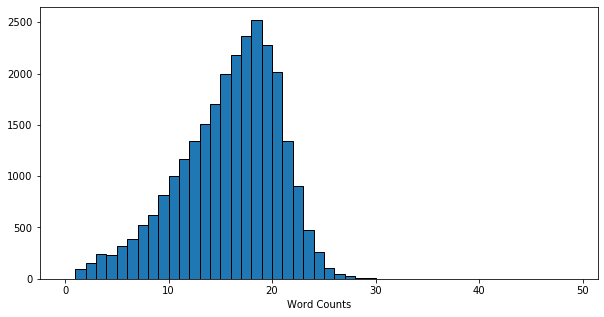

In [64]:
plt.figure(figsize = (10,5))
(n, bins, patches) = plt.hist(words_text_cleaned.values, edgecolor='black',bins = range(50),linewidth=1)
#plt.ylim((0,5000))
plt.xlabel('Word Counts')
plt.show()

In [30]:
bins

array([ 1. ,  3.3,  5.6,  7.9, 10.2, 12.5, 14.8, 17.1, 19.4, 21.7, 24. ])

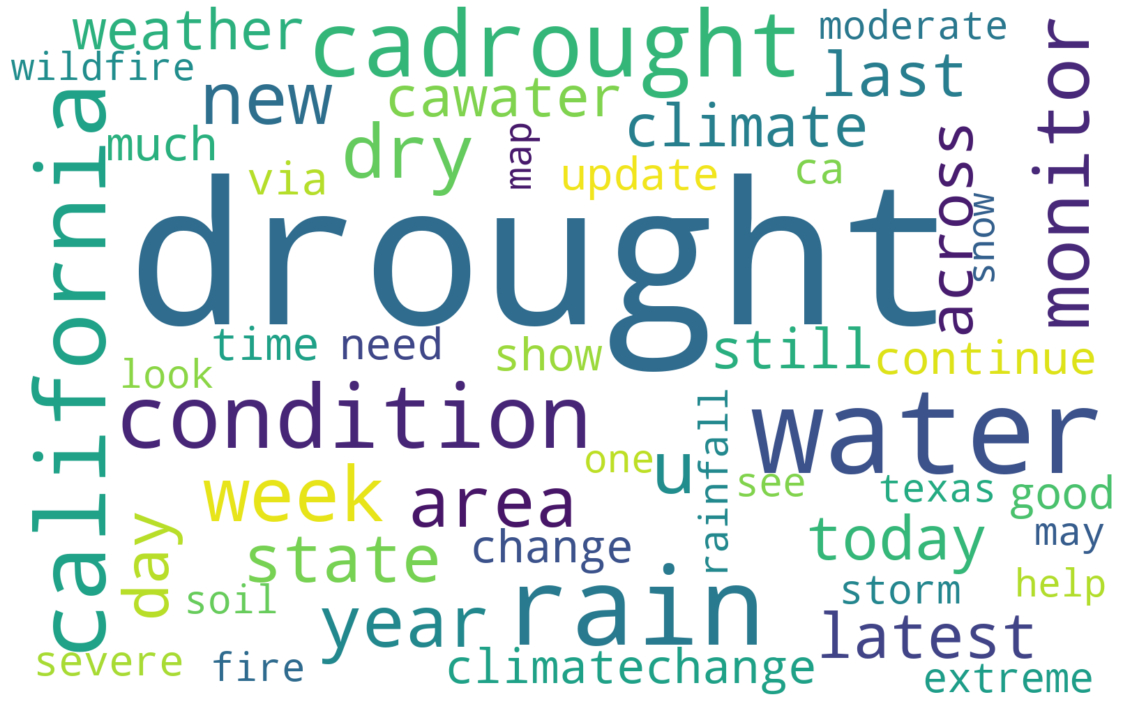

In [82]:
from wordcloud import WordCloud
plt.figure(figsize = (20,20)) 
wc = WordCloud(max_words = 50 , width = 1600 , height = 1000,background_color = "white",collocations=False).generate(" ".join(text_cleaned))
plt.imshow(wc , interpolation = 'bilinear')
plt.axis('off')
plt.savefig("wordcloud_pos.png")